In [118]:
import os, cv2
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt

In [123]:
img = plt.imread("./data/train-1/train-1/0000ef13e37ef70412166725ec034a8a.png")

In [124]:
img.shape

(366, 300, 3)

In [15]:
labels = pd.read_csv('./data/label_map.csv')
train = pd.read_csv('./data/train-from-kaggle.csv')

In [16]:
attributes = [l.split("::")[0] for l in list(labels["attribute_name"])]

In [17]:
np.unique(attributes)

array(['country', 'culture', 'dimension', 'medium', 'tags'], dtype='<U9')

In [18]:
from collections import Counter

cls_counts = Counter(cls for classes in train['attribute_ids'].str.split() for cls in classes)

print(len(cls_counts))

3471


In [24]:
cls_counts

Counter({'448': 11077,
         '2429': 2088,
         '782': 20672,
         '2997': 9498,
         '3231': 217,
         '2730': 1336,
         '3294': 206,
         '3099': 420,
         '2017': 2344,
         '784': 19602,
         '2436': 4864,
         '1715': 1570,
         '23': 9746,
         '3433': 1342,
         '3465': 15840,
         '3322': 1116,
         '3170': 21784,
         '1553': 818,
         '781': 21142,
         '2883': 206,
         '3293': 279,
         '3286': 275,
         '2635': 11653,
         '2088': 2012,
         '785': 20657,
         '3255': 177,
         '3127': 3477,
         '697': 292,
         '354': 62,
         '1060': 11,
         '1449': 7430,
         '1354': 1,
         '2902': 711,
         '2128': 30,
         '2103': 4664,
         '3456': 494,
         '2054': 456,
         '783': 19881,
         '73': 1965,
         '3248': 153,
         '946': 4096,
         '1301': 5846,
         '3017': 255,
         '3221': 136,
         '3466':

In [19]:
label_map = dict(labels[['attribute_id', 'attribute_name']].values.tolist())
not_in_train_labels = set(labels['attribute_id'].astype(str).values) - set(list(cls_counts))
for _id in not_in_train_labels:
    label = label_map[int(_id)]
    print(f'attribute_id: {_id}  attribute_name: {label}')

attribute_id: 1961  attribute_name: medium::paper fringe
attribute_id: 1006  attribute_name: medium::buckshorn
attribute_id: 676  attribute_name: culture::southern german or swiss


In [20]:
# TOP 20 common attribute
for item in sorted(cls_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
    _id, count = item[0], item[1]
    label = label_map[int(_id)]
    print(f'attribute_name: {label}  count: {count}')

attribute_name: tags::men  count: 21784
attribute_name: dimension::large  count: 21142
attribute_name: dimension::medium  count: 20672
attribute_name: dimension::very large  count: 20657
attribute_name: dimension::small  count: 19881
attribute_name: dimension::tiny  count: 19602
attribute_name: tags::women  count: 15840
attribute_name: medium::wood  count: 11653
attribute_name: medium::terracotta  count: 11636
attribute_name: culture::japan  count: 11077
attribute_name: medium::silk  count: 10589
attribute_name: culture::greek  count: 10227
attribute_name: country::egypt  count: 9746
attribute_name: tags::flowers  count: 9498
attribute_name: medium::silver  count: 8699
attribute_name: culture::attic  count: 8630
attribute_name: culture::china  count: 7723
attribute_name: tags::portraits  count: 7527
attribute_name: culture::french  count: 7457
attribute_name: medium::gold  count: 7430


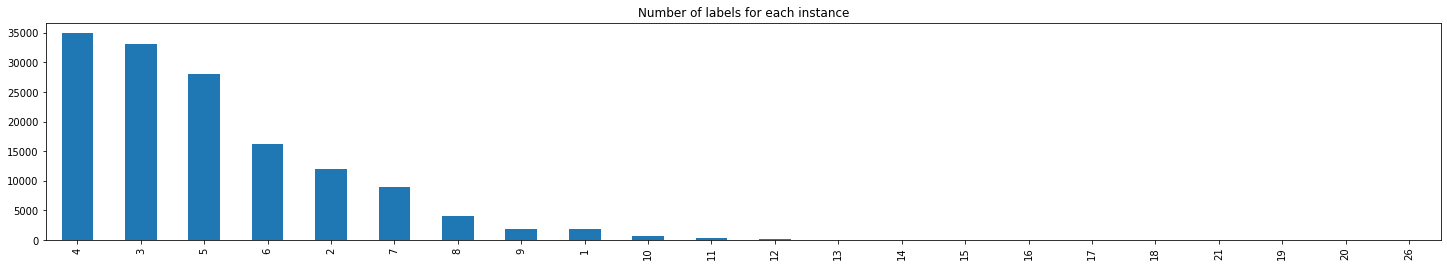

In [26]:
# Number of labels for each instance
import matplotlib.pyplot as plt

df_label_len = train.attribute_ids.str.split(" ").apply(len)
plt.figure(figsize=(25, 4))
df_label_len.value_counts().plot.bar()
plt.title(f"Number of labels for each instance")
plt.show()

In [98]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y=[[int(x) for x in row ] for row in train.attribute_ids.str.split()]
y = mlb.fit_transform(y)
X=list(train.id)

In [99]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train_index, test_index in mskf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

C:\Users\baili\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


KeyboardInterrupt: 

In [155]:
def binarize_prediction(probabilities, threshold: float, argsorted=None,
                        min_labels=1, max_labels=10):
    """
    Return matrix of 0/1 predictions, same shape as probabilities.
    """
    assert probabilities.shape[1] == 6
    if argsorted is None:
        argsorted = probabilities.argsort(axis=1)
    max_mask = _make_mask(argsorted, max_labels)
    min_mask = _make_mask(argsorted, min_labels)
    prob_mask = probabilities > threshold
    return (max_mask & prob_mask) | min_mask

def _make_mask(argsorted, top_n: int):
    mask = np.zeros_like(argsorted, dtype=np.uint8)
    print("Mask {}".format(mask))
    col_indices = argsorted[:, -top_n:].reshape(-1)
    print("col_indices {}".format(col_indices))
    row_indices = [i // top_n for i in range(len(col_indices))]
    print("row_indices {}".format(row_indices))
    mask[row_indices, col_indices] = 1
    print("mask {}".format(mask))
    return mask

In [156]:
probs = np.array([[ 0.2746,  0.2403,  0.3133, -0.1417, -0.7572, -0.4317],
        [ 0.4883,  0.0809,  0.2256,  0.0579, -0.1580, -0.2841],
        [ 0.3774,  0.0150,  0.1803, -0.5649, -0.8239, -0.7004],
        [ 0.2207,  0.0567, -0.2294, -0.0201, -0.2446,  0.0363],
        [ 0.0846,  0.0244,  0.1068,  0.1398, -0.1090, -0.0633]])
argsorted = probs.argsort(axis=1)

In [158]:
for threshold in [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]:
    out = binarize_prediction(probs, threshold, argsorted, min_labels=1, max_labels=3)
    break

Mask [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
col_indices [1 0 2 1 2 0 1 2 0 5 1 0 0 2 3]
row_indices [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
mask [[1 1 1 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 0 0 0]
 [1 1 0 0 0 1]
 [1 0 1 1 0 0]]
Mask [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
col_indices [2 0 0 0 3]
row_indices [0, 1, 2, 3, 4]
mask [[0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]]


In [159]:
probs

array([[ 0.2746,  0.2403,  0.3133, -0.1417, -0.7572, -0.4317],
       [ 0.4883,  0.0809,  0.2256,  0.0579, -0.158 , -0.2841],
       [ 0.3774,  0.015 ,  0.1803, -0.5649, -0.8239, -0.7004],
       [ 0.2207,  0.0567, -0.2294, -0.0201, -0.2446,  0.0363],
       [ 0.0846,  0.0244,  0.1068,  0.1398, -0.109 , -0.0633]])

In [160]:
out

array([[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0]], dtype=uint8)